In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [3]:
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 8\ Assignment/model_gn.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 8\ Assignment/utils.py /content

In [4]:
import model_gn
import utils
from model_gn import Net
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True


In [5]:
# Train data transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test data transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [6]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.cifar.CIFAR10,
 50000,
 2,
 (50000, 32, 32, 3),
 (10000, 32, 32, 3))

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


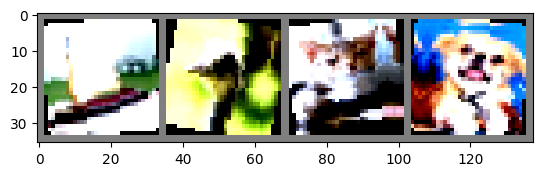

ship  bird  cat   dog  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

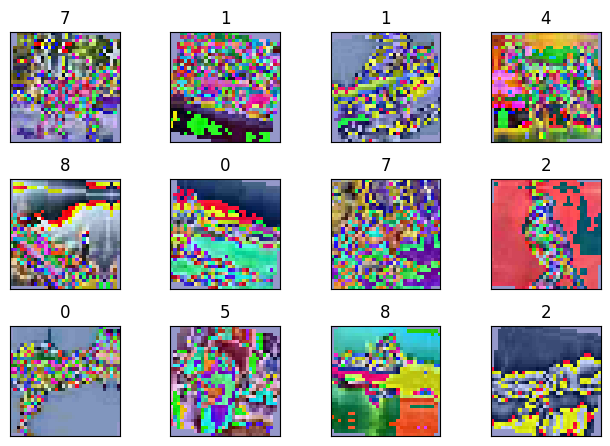

In [10]:
#batch_data, batch_label = next(iter(train_loader))
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  #plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(transforms.ToPILImage()(batch_data[i]),interpolation='nearest')
  #plt.imshow(batch_data[i].squeeze(0))
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=1.6626 Batch_id=97 Accuracy=28.21: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 1.6323, Accuracy: 4036/10000 (40.36%)

EPOCH: 1


Train: Loss=1.5568 Batch_id=97 Accuracy=41.79: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 1.4504, Accuracy: 4673/10000 (46.73%)

EPOCH: 2


Train: Loss=1.3230 Batch_id=97 Accuracy=47.80: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]


Test set: Average loss: 1.3360, Accuracy: 5147/10000 (51.47%)

EPOCH: 3


Train: Loss=1.3648 Batch_id=97 Accuracy=51.96: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 1.1519, Accuracy: 5815/10000 (58.15%)

EPOCH: 4


Train: Loss=1.2714 Batch_id=97 Accuracy=55.82: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]


Test set: Average loss: 1.1551, Accuracy: 5801/10000 (58.01%)

EPOCH: 5


Train: Loss=1.1126 Batch_id=97 Accuracy=57.91: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]


Test set: Average loss: 1.0083, Accuracy: 6383/10000 (63.83%)

EPOCH: 6


Train: Loss=1.1194 Batch_id=97 Accuracy=59.95: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 1.0112, Accuracy: 6349/10000 (63.49%)

EPOCH: 7


Train: Loss=1.0008 Batch_id=97 Accuracy=60.90: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.9754, Accuracy: 6489/10000 (64.89%)

EPOCH: 8


Train: Loss=1.1741 Batch_id=97 Accuracy=62.86: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.9329, Accuracy: 6688/10000 (66.88%)

EPOCH: 9


Train: Loss=1.0998 Batch_id=97 Accuracy=62.95: 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]


Test set: Average loss: 0.8900, Accuracy: 6859/10000 (68.59%)

EPOCH: 10


Train: Loss=0.9866 Batch_id=97 Accuracy=64.76: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


Test set: Average loss: 0.8945, Accuracy: 6766/10000 (67.66%)

EPOCH: 11


Train: Loss=0.8562 Batch_id=97 Accuracy=65.29: 100%|██████████| 98/98 [00:36<00:00,  2.71it/s]


Test set: Average loss: 0.8869, Accuracy: 6847/10000 (68.47%)

EPOCH: 12


Train: Loss=0.9967 Batch_id=97 Accuracy=65.90: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]


Test set: Average loss: 0.8470, Accuracy: 6994/10000 (69.94%)

EPOCH: 13


Train: Loss=0.9879 Batch_id=97 Accuracy=66.96: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.8127, Accuracy: 7118/10000 (71.18%)

EPOCH: 14


Train: Loss=0.8793 Batch_id=97 Accuracy=67.53: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.8013, Accuracy: 7156/10000 (71.56%)

EPOCH: 15


Train: Loss=1.0134 Batch_id=97 Accuracy=68.06: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


Test set: Average loss: 0.8113, Accuracy: 7134/10000 (71.34%)

EPOCH: 16


Train: Loss=0.9234 Batch_id=97 Accuracy=68.54: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]


Test set: Average loss: 0.7892, Accuracy: 7238/10000 (72.38%)

EPOCH: 17


Train: Loss=0.8441 Batch_id=97 Accuracy=69.04: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]


Test set: Average loss: 0.7672, Accuracy: 7333/10000 (73.33%)

EPOCH: 18


Train: Loss=0.8992 Batch_id=97 Accuracy=69.12: 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]


Test set: Average loss: 0.7513, Accuracy: 7394/10000 (73.94%)

EPOCH: 19


Train: Loss=0.7915 Batch_id=97 Accuracy=70.14: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.7337, Accuracy: 7421/10000 (74.21%)



In [15]:
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect

In [16]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.values())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        plt.imshow(d.cpu().numpy().transpose(1, 2, 0))
        if i+1 == 5*(count/5):
            break

In [17]:
class_map = {
    'ZERO': 'plane',
    'ONE': 'car',
    'TWO': 'bird',
    'THREE': 'cat',
    'FOUR': 'deer',
    'FIVE': 'dog',
    'SIX': 'frog',
    'SEVEN': 'horse',
    'EIGHT': 'ship',
    'NINE': 'truck'
}

Total Incorrect Predictions 2579


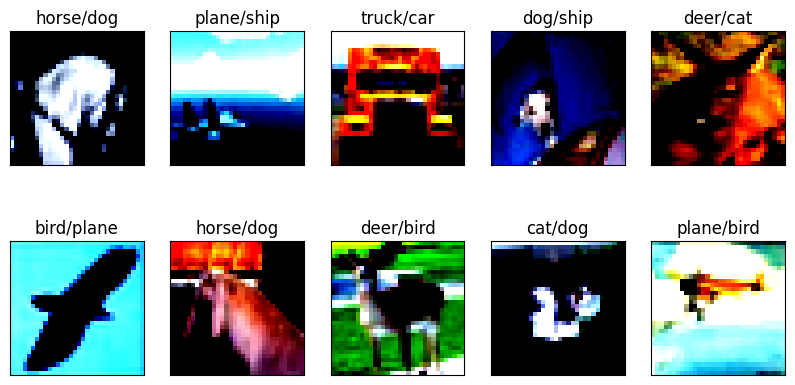

In [18]:
incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)